## Demand Forecasting
### Store Item Demand Forecasting Challenge
### https://www.kaggle.com/c/demand-forecasting-kernels-only

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

## Loading Data

In [3]:
train = pd.read_csv('../datasets/demand_forecasting/train.csv', parse_dates=['date'])
#Train set is first 3 month of 2018
test = pd.read_csv('../datasets/demand_forecasting/test.csv', parse_dates=['date'])

sample_sub = pd.read_csv('../datasets/demand_forecasting/sample_submission.csv')

df = pd.concat([train, test], sort=False)

## EDA

In [5]:
min_date=df["date"].min()
max_date=df["date"].max()
print("Oldest date= {} \nRecent date= {}".format(min_date,max_date))

Oldest date= 2013-01-01 00:00:00 
Recent date= 2018-03-31 00:00:00


In [7]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [8]:
print("There are {} different store".format(df["store"].nunique()))
print("There are {} different item".format(df["item"].nunique()))

There are 10 different store
There are 50 different item


In [9]:
df.groupby("store")["item"].nunique()
#This mean all of the items were sold at each shop

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [11]:
df.groupby(["store","item"]).agg({"sales":"sum"})
#this shows number of sales for each item at each store

sales
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [12]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})
#let observe other sales statistics

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

## Feature Engineering

### Date Features

In [13]:
def create_date_features(df):
    df['month'] = df.date.dt.month #which month (0-12)
    df['day_of_month'] = df.date.dt.day # which day of month
    df['day_of_year'] = df.date.dt.dayofyear # which day of year
    df['week_of_year'] = df.date.dt.weekofyear # which week of year
    df['day_of_week'] = df.date.dt.dayofweek # which day of week
    df['year'] = df.date.dt.year # which year
    df["is_wknd"] = df.date.dt.weekday // 4 # is this day weekend or not
    df['is_month_start'] = df.date.dt.is_month_start.astype(int) #is this day beginning of month
    df['is_month_end'] = df.date.dt.is_month_end.astype(int) # is this day ending of month
    return df
df=create_date_features(df)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [15]:
df.groupby(["store","month","item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                     sum       mean median        std
store month item                                     
1     1     1     2125.0  13.709677   13.0   4.397413
            2     5591.0  36.070968   35.0   8.629540
            3     3503.0  22.600000   22.0   5.951754
            4     2101.0  13.554839   13.0   4.662843
            5     1793.0  11.567742   11.0   3.903078
...                  ...        ...    ...        ...
10    12    46    7685.0  49.580645   49.0  11.227790
            47    2840.0  18.322581   18.0   5.557183
            48    6901.0  44.522581   44.0   9.969652
            49    3838.0  24.761290   24.0   6.677238
            50    8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

### Random Noise

In [16]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))
# In order to avoid over-fitting we will use this function

###  Lag/Shifted Features

In [17]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


In [18]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe
# this function creates features about previous sales of that item. We used random_noise to avoid over-fit.

In [20]:
df=lag_features(df,[91, 98, 105, 112, 119, 126, 182, 364, 546, 728])


,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,43.590603,52.632933,65.646998,65.630521,66.856724,81.076738,80.428230,61.882530,95.952910,72.018967
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,62.573735,51.865532,65.872040,59.985400,77.121087,83.554159,80.259031,74.323376,82.439448,65.565044
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,56.750135,62.531536,73.896323,64.196316,73.362246,86.987984,82.730712,68.138615,100.318254,70.358399
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,74.278731,75.957645,71.641414,65.419171,66.524544,83.506838,91.397293,68.491942,75.952468,84.427008
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,61.317156,72.114740,52.340571,70.794386,49.753475,78.243382,104.723844,100.549520,96.068144,80.897483


In [23]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,43.590603,52.632933,65.646998,65.630521,66.856724,81.076738,80.428230,61.882530,95.952910,72.018967
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,62.573735,51.865532,65.872040,59.985400,77.121087,83.554159,80.259031,74.323376,82.439448,65.565044
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,56.750135,62.531536,73.896323,64.196316,73.362246,86.987984,82.730712,68.138615,100.318254,70.358399
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,74.278731,75.957645,71.641414,65.419171,66.524544,83.506838,91.397293,68.491942,75.952468,84.427008
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,61.317156,72.114740,52.340571,70.794386,49.753475,78.243382,104.723844,100.549520,96.068144,80.897483


In [24]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Rolling Mean Features

In [25]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})
#The average of the previous values gives us some information about trend

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


In [26]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe
#This function creates feature about the average of previous values
df=roll_mean_features(df,[365,546])


### Exponentially Weighted Features

In [27]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})


,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


In [31]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]
df=ewm_features(df,alphas,lags)


##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sale

                            0.00         0.05          0.50          0.95          0.99          1.00
store                        1.0     1.000000      5.500000     10.000000     10.000000     10.000000
item                         1.0     3.000000     25.500000     48.000000     50.000000     50.000000
sales                        0.0    16.000000     47.000000    107.000000    135.000000    231.000000
id                           0.0  2249.950000  22499.500000  42749.050000  44549.010000  44999.000000
month                        1.0     1.000000      6.000000     12.000000     12.000000     12.000000
...                          ...          ...           ...           ...           ...           ...
sales_ewm_alpha_05_lag_180   2.0    16.720567     47.287810    104.520711    128.183953    201.730822
sales_ewm_alpha_05_lag_270   2.0    16.521703     46.596871    102.578388    125.636612    201.730822
sales_ewm_alpha_05_lag_365   2.0    16.288943     45.837082    100.339476    122.8

In [32]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,43.590603,52.632933,65.646998,65.630521,66.856724,81.076738,80.428230,61.882530,95.952910,72.018967,88.860063,85.326823,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,62.573735,51.865532,65.872040,59.985400,77.121087,83.554159,80.259031,74.323376,82.439448,65.565044,87.073738,84.457126,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,87.348615,116.916565,63.027108,82.174524,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,56.750135,62.531536,73.896323,64.196316,73.362246,86.987984,82.730712,68.138615,100.318254,70.358399,88.005245,86.116328,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,74.278731,75.957645,71.641414,65.419171,66.524544,83.506838,91.397293,68.491942,75.952468,84.427008,87.979656,85.479577,73.257320,74.370379,71.987423,66.935919,99.166487,100.046678,68.218343,79.954327,82.582997,72.519244,73.683198,71.948850,66.846786,99.261778,101.083682,68.377473,80.822562,82.133115,71.007644,72.151037,71.783969,66.606893,99.211911,103.109627,68.550876,82.314892,81.134709,69.403475,70.452564,71.480559,66.298892,98.791375,105.022491,68.602440,83.485707,80.000156,66.038719,66.956088,70.379233,65.541

## Encoding and Normilazation

In [33]:
##############
#One Hot Encoder
##############
df=pd.get_dummies(df,columns=["store","item","day_of_week","month"])
#for model

In [34]:
########################
# Converting sales to log(1+sales)
########################
df['sales'] = np.log1p(df["sales"].values)
#to get less iteration time for model training

## Model

### Custom Cost Function

In [35]:
# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


In [36]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

### Time Based Validation Set

In [37]:
# untill the 2017
train = df.loc[(df["date"] < "2017-01-01"), :]

# first 3 month of 2017
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]


In [40]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]
Y_train=train["sales"]
x_train=train[cols]
Y_val=val["sales"]
x_val=val[cols]
#We have created train and validation sets

### Time Series Model with LightGBM

In [43]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [42]:
# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs

In [45]:
lgbtrain = lgb.Dataset(data=x_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=x_val, label=Y_val, reference=lgbtrain, feature_name=cols)
#We should convert our dataframe before we create a model
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126237 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0514237	training's SMAPE: 17.6133	valid_1's l2: 0.0532632	valid_1's SMAPE: 17.4992
[200]	training's l2: 0.0352259	training's SMAPE: 14.5753	valid_1's l2: 0.0369991	valid_1's SMAPE: 14.8966
[300]	training's l2: 0.0324332	training's SMAPE: 14.0128	valid_1's l2: 0.034148	valid_1's SMAPE: 14.4478
[400]	training's l2: 0.0313809	training's SMAPE: 13.7975	valid_1's l2: 0.0332901	valid_1's SMAPE: 14.2887
[500]	training's l2: 0.030716	training's SMAPE: 13.6656	valid_1's l2: 0.0326855	valid_1's SMAPE: 14.1544
[600]	training's l2: 0.0302255	training's SMAPE: 13.5691	valid_1's l2: 0.0322345	valid_1's SMAPE: 14.0488
[700]	training's l2: 0.0298676	training's SMAPE: 13.4979	valid_1's l2: 0.0319113	valid_1's SMAPE: 13.9714
[800]	training's l2: 0.0295887	tr

In [46]:
y_pred_val=model.predict(x_val,num_iteration=model.best_iteration)
#Here we predict first 3 month of 2017

In [48]:
error=smape(np.expm1(y_pred_val), np.expm1(Y_val))
print("Error is {}".format(error))

Error is 13.829302721456955


### Feature Importance

In [49]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

In [50]:
plot_lgb_importances(model,num=10)
#These are the most important 10 features

                        feature  split       gain
17          sales_roll_mean_546    939  54.343499
13                sales_lag_364   1259  13.267646
16          sales_roll_mean_365    608   9.911488
60   sales_ewm_alpha_05_lag_365    371   4.920894
18   sales_ewm_alpha_095_lag_91     99   2.921020
1                   day_of_year    729   2.010075
54    sales_ewm_alpha_05_lag_91     92   1.876629
3                       is_wknd    224   1.210317
123               day_of_week_0    233   1.179150
141                    month_12    322   1.170682


,feature,split,gain
17,sales_roll_mean_546,939,54.343499
13,sales_lag_364,1259,13.267646
16,sales_roll_mean_365,608,9.911488
60,sales_ewm_alpha_05_lag_365,371,4.920894
18,sales_ewm_alpha_095_lag_91,99,2.921020
...,...,...,...
107,item_35,0,0.000000
111,item_39,0,0.000000
74,item_2,0,0.000000
86,item_14,0,0.000000


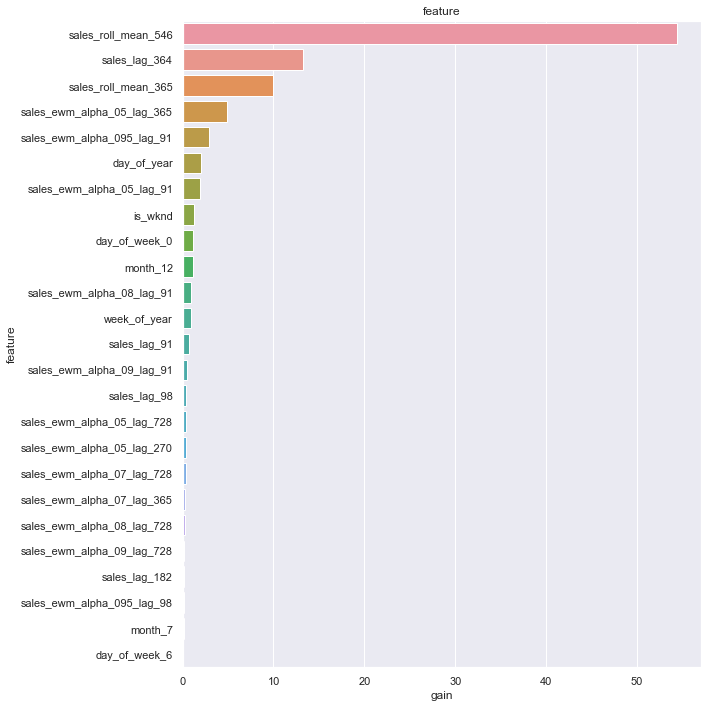

,feature,split,gain
17,sales_roll_mean_546,939,54.343499
13,sales_lag_364,1259,13.267646
16,sales_roll_mean_365,608,9.911488
60,sales_ewm_alpha_05_lag_365,371,4.920894
18,sales_ewm_alpha_095_lag_91,99,2.921020
...,...,...,...
107,item_35,0,0.000000
111,item_39,0,0.000000
74,item_2,0,0.000000
86,item_14,0,0.000000


In [51]:
plot_lgb_importances(model, num=30, plot=True)

### Final Model

In [52]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]


In [53]:

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161249 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [59]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)
test["sales"]=test_preds